In [17]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pdb
import os
from pycocotools.coco import COCO
# from skimage import io
from PIL import Image

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

In [18]:
data_type = 'train' 

src_root = '/opt/ml/finalproject/data/' + data_type
src_file = src_root + '/cat_modified_'+ data_type +'_dummy.json'
src_desc = data_type # a name (identifier) for the dataset

coco_obj = COCO(src_file)

loading annotations into memory...
Done (t=0.12s)
creating index...
index created!


In [19]:
# Reading the json file
with open(src_file, 'r') as f:
    root = json.load(f)

In [20]:
# Basic High Level Information

n_images = len(root['images'])
n_boxes = len(root['annotations'])
n_categ = len(root['categories'])

# height, width
heights = [x['height'] for x in root['images']]
widths = [x['width'] for x in root['images']]


print('Dataset Name: ',src_desc)
print('Number of images: ',n_images)
print('Number of bounding boxes: ', n_boxes)
print('Number of classes: ', n_categ)
print('Max min avg height: ', max(heights), min(heights), int(sum(heights)/len(heights)))
print('Max min avg width: ', max(widths), min(widths), int(sum(widths)/len(widths)))

Dataset Name:  train
Number of images:  5239
Number of bounding boxes:  11773
Number of classes:  38
Max min avg height:  666 99 487
Max min avg width:  1498 128 668


# 이미지 당 객체 개수

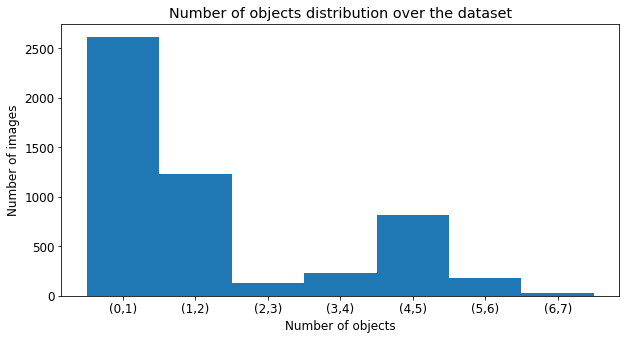

Number of images having atleast one box:  5236
Min number of boxes per image:  1
Max number of boxes per image:  7
Avg number of boxes per image:  2


In [21]:
# Objects per image distribution

img2nboxes = {} # mapping "image id" to "number of boxes"

for ann in root['annotations']:
    img_id = ann['image_id']
    
    if img_id in img2nboxes.keys():
        img2nboxes[img_id] += 1
    else:
        img2nboxes[img_id] = 1

nboxes_list = list(img2nboxes.values())

min_nboxes = min(nboxes_list)
max_nboxes = max(nboxes_list)
avg_nboxes = int(sum(nboxes_list)/len(nboxes_list))

out = pd.cut(nboxes_list, bins=np.arange(0,max_nboxes+1,1), include_lowest=True)

counts = out.value_counts().values
labels = [(int(i.left),int(i.right)) for i in out.value_counts().index.categories]

graph_xind = [i[0] for i in labels] 
ticks = [ '('+str(i[0])+','+ str(i[1])+')' for i in labels]

plt.figure(figsize=(10,5))
plt.bar(graph_xind, counts, tick_label=ticks, width=1)
plt.xlabel('Number of objects')
plt.ylabel('Number of images')
plt.title('Number of objects distribution over the dataset')
plt.show()

print("Number of images having atleast one box: ", len(nboxes_list))
print("Min number of boxes per image: ", min_nboxes)
print("Max number of boxes per image: ", max_nboxes)
print("Avg number of boxes per image: ", avg_nboxes)

# 클래스 개수 분포

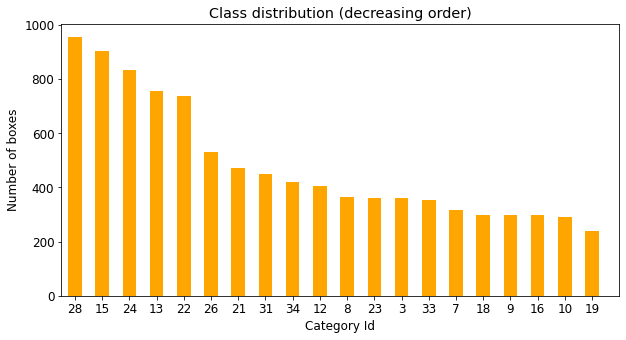

32 -> ZippoOil, 3 -> Axe, 22 -> Scissors, 33 -> Plier, 13 -> Knife, 26 -> Spanner, 28 -> SupplymentaryBattery, 8 -> Gun, 11 -> HandCuffs, 15 -> Lighter, 34 -> Chisel, 23 -> Screwdriver, 37 -> Throwing Knife, 1 -> Alcohol, 20 -> PrtableGas, 21 -> Saw, 10 -> Hammer, 17 -> Match, 30 -> Thinner, 18 -> MetalPipe, 25 -> SolidFuel, 12 -> HDD, 24 -> SmartPhone, 31 -> USB, 2 -> Awl, 19 -> NailClippers, 9 -> GunParts, 7 -> Firecracker, 0 -> Aerosol, 5 -> Battery, 35 -> Electronic cigarettes, 36 -> Electronic cigarettes(Liquid), 6 -> Bullet, 16 -> Liquid, 4 -> Bat, 14 -> Laptop, 29 -> TabletPC, 27 -> SSD, 

In [22]:
# Class distribution
class2nboxes = {} 

for ann in root['annotations']:
    cat_id = ann['category_id']
    
    if cat_id in class2nboxes.keys():
        class2nboxes[cat_id] += 1
    else:
        class2nboxes[cat_id] = 1

sorted_c2nb = [(k,v)for k, v in sorted(class2nboxes.items(), reverse=True, key=lambda item: item[1])]

# top 20 classes
top = min(len(sorted_c2nb),20)

# to plot
y = [i[1] for i in sorted_c2nb[:top]]
x = [i[0] for i in sorted_c2nb[:top]]

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(y)),y, width=0.5,tick_label=x,color='orange')
plt.xlim(-0.5,len(y))
plt.xlabel('Category Id')
plt.ylabel('Number of boxes')
plt.title('Class distribution (decreasing order)')
plt.show()



categ_map = {x['id']: x['name'] for x in root['categories']}
for k in categ_map.keys():
    print(k,'->',categ_map[k], end=", ")

# 이미지 bbox 시각화

['Plier', 'Plier']


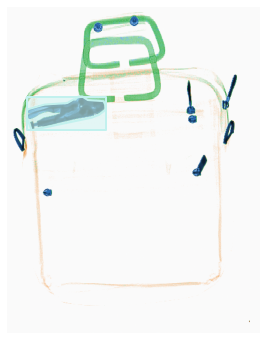

In [24]:
# generate a random image
# np.random.seed(1004)
imgIds = [i['id'] for i in root['images']]
catIds = [i['id'] for i in root['categories']]
# img = coco_obj.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
img = coco_obj.loadImgs(imgIds[1046])[0]
img_path= os.path.join(src_root, img['path'][1:], img['file_name'])
# I = io.imread(img_path)
I = Image.open(img_path)

# plot annotations
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(I)
annIds = coco_obj.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco_obj.loadAnns(annIds)

coco_obj.showAnns(anns, draw_bbox=True)
classes = [categ_map[a['category_id']] for a in anns]
print(classes)
